In [1]:
import gc
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset

In [2]:
from source_code.common import (log10, 
                                plot_figure, 
                                plot_slices, 
                                perform_op_over_data, 
                                get_margin_error)
from source_code.network import Network, free_device
from source_code.real_data_experiment import dataset_sampling, get_bounds_mnist

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
GAIN = 0.5
BIAS_VALUE = 0.5
DATA_MODE = 'mnist'

In [5]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight, gain=GAIN)
        m.bias.data.fill_(BIAS_VALUE)

In [6]:
tr_mnist = pd.read_csv('./datasets/mnist_train.csv')
te_mnist = pd.read_csv('./datasets/mnist_train.csv')

In [7]:
tr_mnist['label'] = tr_mnist.label.astype('uint8')
te_mnist['label'] = te_mnist.label.astype('uint8')

# MNIST

In [23]:
# Hyperparams
FLAGS = {
    "batch_size": 16, 
    "input_dim": 784,
    "n_classes" : 10,
    "width" : 1000,
    "depth" : 2,
    "learning_rate" : 0.1,
    "threshold" : 0.01, # Proportion of training points can we ignore
    "margin" : 10, # Margin that needs to be achieved on most of the training points
    "n_test" : 4096,
    "n_train_list" : [512, 1024,2048, 4096, 8192, 16384], # To experiment with larger dataset sizes,
    "seed" : 8312
}

In [24]:
dir_path = './experiment_result/'
sub_dir_path =  dir_path + '{}_gain_{}_bias_{}/'.format(DATA_MODE, GAIN, BIAS_VALUE)
FLAGS['path'] = sub_dir_path

In [25]:
test_error_path = FLAGS['path'] + 'test_error.png'
test_bound_path = FLAGS['path'] + 'test_error_bound.png'
test_norm_path = FLAGS['path'] + 'test_spectral_norm.png'

In [26]:
os.makedirs(dir_path, exist_ok=True)
os.makedirs(sub_dir_path, exist_ok=True)

In [27]:
init_model_3 = Network(**FLAGS)
init_model_3 = init_model_3.to(device)
torch.cuda.manual_seed(FLAGS['seed'])
torch.manual_seed(FLAGS['seed'])
init_model_3 = init_model_3.apply(init_weights)
initial_weights_3 = list(init_model_3.parameters())
initial_dict_3 = init_model_3.state_dict()
del init_model_3
gc.collect()

124

In [28]:
# We sample a test set, and multiple independent draws of training sets of varying sizes
test_dataset = dataset_sampling(te_mnist, FLAGS['n_test'], binary=False)

# Note that the function get_random_data is not visible in the blog, but can be found in the notebook after downloading
FLAGS["n_experiments"] = len(FLAGS["n_train_list"])
training_dataset_list = [[] for n_train in FLAGS["n_train_list"]]

for k in range(FLAGS["n_experiments"]):
    training_dataset_list[k] = dataset_sampling(tr_mnist, FLAGS["n_train_list"][k], binary=False)

data shape :  (4096, 785)
data shape :  (512, 785)
data shape :  (1024, 785)
data shape :  (2047, 785)
data shape :  (4096, 785)
data shape :  (8192, 785)
data shape :  (16383, 785)


In [52]:
final_weights_list = [[] for k in range(FLAGS["n_experiments"])] # Weights learned for each dataset size
final_dicts = [[] for k in range(FLAGS["n_experiments"])]
test_errors_list = [0 for k in range(FLAGS["n_experiments"])] # Test error for each dataset size

for k in range(FLAGS["n_experiments"]):
    print(f"\n[INFO] Experiment no. {k + 1} running...")
    
    # Define model
    model_3 = Network(**FLAGS)
    model_3 = model_3.to(device)
    model_3.load_state_dict(initial_dict_3)
    
    # Define criterion and optimizer
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model_3.parameters(), lr=FLAGS["learning_rate"])
    
    # Train
    print(f"[INFO] ...training!")
    epoch = 0
    train_margin_error = 1.0
    
    while train_margin_error > FLAGS["threshold"]:
        epoch += 1
        outs = perform_op_over_data(model_3, training_dataset_list[k],\
                                    criterion, optimizer, device,
                                    batch_size=FLAGS["batch_size"])  
        train_margin_error = get_margin_error(model_3, training_dataset_list[k],\
                                              criterion, optimizer, \
                                              device, batch_size=FLAGS["batch_size"],\
                                              mode=DATA_MODE)
        print(f"[INFO] [EXP{str(k + 1).zfill(2)}] Epoch {epoch:2d}\n[INFO] [EXP{str(k + 1).zfill(2)}] current margin error: {train_margin_error:.4f}")
        
    # Compute test error
    print(f"[INFO] ...test!\n")
    test_errors_list[k] = get_margin_error(model_3, test_dataset, \
                                           criterion, optimizer,\
                                           device,batch_size=FLAGS['batch_size'],\
                                           mode=DATA_MODE
                                          ) 
    print(f"[INFO] test current margin error: {test_errors_list[k]:.4f}")
    final_weights_list[k] = list(model_3.parameters())
    final_dicts[k] = model_3.state_dict()
    torch.cuda.empty_cache()

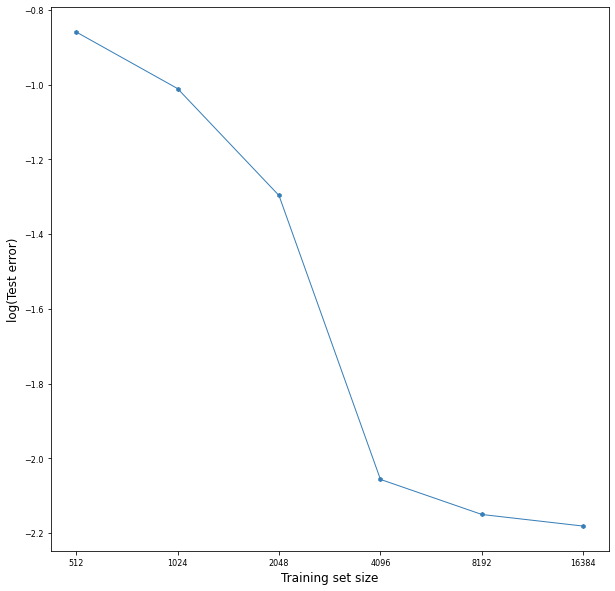

In [30]:
plot_figure("Training set size", "Test error", FLAGS["n_train_list"], 
            test_errors_list, xticks=FLAGS["n_train_list"], save_path=test_error_path)

In [31]:
bounds = [[],[],[]] 

for k in range(FLAGS["n_experiments"]):
    spectral_norms = [np.linalg.norm(w, ord=2) for w in free_device(final_weights_list[k])]
    bound_0, bound_1, bound_2 = get_bounds_mnist(free_device(initial_weights_3), free_device(final_weights_list[k]), \
                                                 spectral_norms, training_dataset_list[k].tensors[0], **FLAGS)
    bounds[0] += [bound_0]
    bounds[1] += [bound_1]
    bounds[2] += [bound_2]

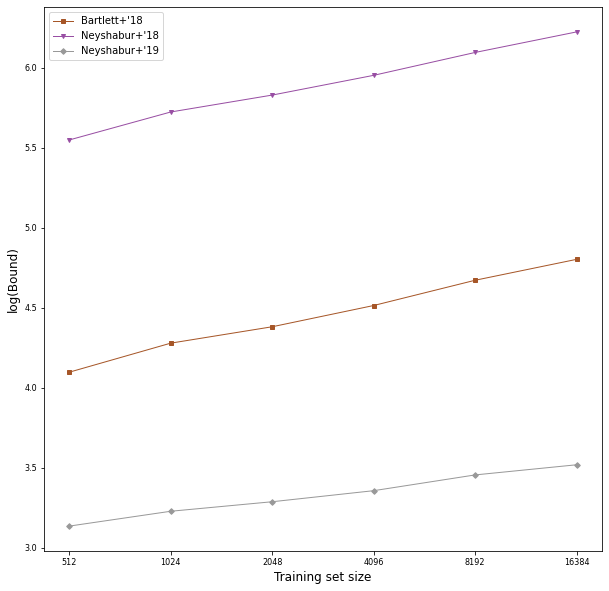

In [33]:
plot_figure("Training set size", "Bound", FLAGS["n_train_list"], bounds, xticks=FLAGS["n_train_list"], 
            save_path=test_bound_path,ylabels=["Bartlett+'18", "Neyshabur+'18", "Neyshabur+'19"])

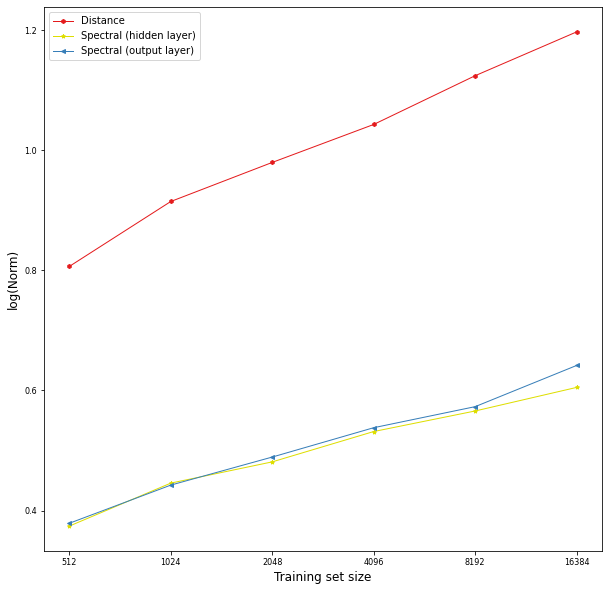

In [34]:
distances = [np.linalg.norm([np.linalg.norm(w[0] - w[1]) for w in zip(free_device(final_weights_list[k]), free_device(initial_weights_3))]) 
             for k in range(FLAGS["n_experiments"])]
hidden_layer_spectral_norm = [np.linalg.norm(free_device(final_weights_list[k])[0], ord=2) for k in range(FLAGS["n_experiments"])]
output_layer_spectral_norm = [np.linalg.norm(free_device(final_weights_list[k])[2], ord=2) for k in range(FLAGS["n_experiments"])]
plot_figure("Training set size", "Norm", FLAGS["n_train_list"],
            [distances, hidden_layer_spectral_norm, output_layer_spectral_norm],
            xticks=FLAGS["n_train_list"], 
            save_path=test_norm_path,
            ylabels=["Distance", "Spectral (hidden layer)", "Spectral (output layer)"])

In [33]:
# Hyperparams
FLAGS = {
    "batch_size": [1, 4, 16, 64, 256, 1024], 
    "input_dim": 784,
    "n_classes" : 10,
    "width" : 1000,
    "depth" : 2,
    "learning_rate" : 0.01,
    "threshold" : 0.02, # Proportion of training points can we ignore
    "margin" : 10, # Margin that needs to be achieved on most of the training points
    "n_train" : 4096,
    "n_test" : 2048,
    "seed" : 8312
}

In [34]:
GAIN = 0.5
BIAS_VALUE = 1.0

In [35]:
dir_path = './experiment_result/'
sub_dir_path =  dir_path + '{}_gain_{}_bias_{}_batch2/'.format(DATA_MODE, GAIN, BIAS_VALUE)
FLAGS['path'] = sub_dir_path

In [36]:
os.makedirs(dir_path, exist_ok=True)
os.makedirs(sub_dir_path, exist_ok=True)

In [37]:
test_error_path = FLAGS['path'] + 'test_error.png'
test_bound_path = FLAGS['path'] + 'test_error_bound.png'
test_norm_path = FLAGS['path'] + 'test_spectral_norm.png'

In [38]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight, gain=GAIN)
        m.bias.data.fill_(BIAS_VALUE)

In [39]:
init_model_4 = Network(**FLAGS)
init_model_4 = init_model_4.to(device)
torch.cuda.manual_seed(FLAGS['seed'])
torch.manual_seed(FLAGS['seed'])
init_model_4 = init_model_4.apply(init_weights)
initial_weights_4 = list(init_model_4.parameters())
initial_dict_4 = init_model_4.state_dict()
del init_model_4
gc.collect()

5461

In [40]:
# We sample a test set, and multiple independent draws of training sets of varying sizes
training_dataset_batch = dataset_sampling(tr_mnist, FLAGS["n_train"], binary=False)
test_dataset_batch = dataset_sampling(te_mnist, FLAGS['n_test'], binary=False)

# Note that the function get_random_data is not visible in the blog, but can be found in the notebook after downloading
FLAGS["n_experiments"] = len(FLAGS["batch_size"])

data shape :  (4096, 785)
data shape :  (2047, 785)


In [41]:
from torch.utils.data import DataLoader
from tqdm import tqdm

In [42]:
def perform_op_over_data_batch(model, dataset, criterion, optimizer, device, batch_size, eval=False):
    outs = []
    dataloader = DataLoader(dataset, batch_size=batch_size, pin_memory=True)
    
    if eval:
        model.eval()
    else:
        model.train()
        
    for idx, (inputs, labels) in tqdm(enumerate(dataloader), leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        if eval == False:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        else:
            with torch.no_grad():
                outputs = model(inputs) 
        outs.append(outputs.detach().cpu())
    model_parameters = list(model.parameters())
    return outs, model_parameters

In [51]:
final_weights_list_batch = [[] for k in range(FLAGS["n_experiments"])] # Weights learned for each dataset size
# final_dicts_batch = [[] for k in range(FLAGS["n_experiments"])]
test_errors_list_batch = [0 for k in range(FLAGS["n_experiments"])] # Test error for each dataset size

for k in range(FLAGS["n_experiments"]):
    print(f"\n[INFO] Experiment no. {k + 1} running...")
    
    # Define model
    model_4 = Network(**FLAGS)
    model_4 = model_4.to(device)
    model_4.load_state_dict(initial_dict_4)
    
    # Define criterion and optimizer
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model_4.parameters(), lr=FLAGS["learning_rate"])
    
    # Train
    print(f"[INFO] ...training! batch_size : ", str(FLAGS["batch_size"][k]))
    epoch = 0
    train_margin_error = 1.0
    
    while train_margin_error > FLAGS["threshold"]:
        epoch += 1
        outs, model_parameters = perform_op_over_data_batch(model_4, training_dataset_batch,\
                                        criterion, optimizer, device,
                                        batch_size=FLAGS["batch_size"][k])  
        train_margin_error = get_margin_error(model_4, training_dataset_batch,\
                                              criterion, optimizer, \
                                              device, batch_size=FLAGS["batch_size"][k],\
                                              mode=DATA_MODE)
        print(f"[INFO] [EXP{str(k + 1).zfill(2)}] Epoch {epoch:2d}\n[INFO] [EXP{str(k + 1).zfill(2)}] current margin error: {train_margin_error:.4f}")
        
    # Compute test error
    print(f"[INFO] ...test!\n")
    test_errors_list_batch[k] = get_margin_error(model_4, test_dataset_batch, \
                                           criterion, optimizer,\
                                           device,batch_size=FLAGS['batch_size'][k],\
                                           mode=DATA_MODE
                                          ) 
    print(f"[INFO] test current margin error: {test_errors_list_batch[k]:.4f}")
    final_weights_list_batch[k] = model_parameters
#     final_dicts_batch[k] = model_4.state_dict()
    torch.cuda.empty_cache()

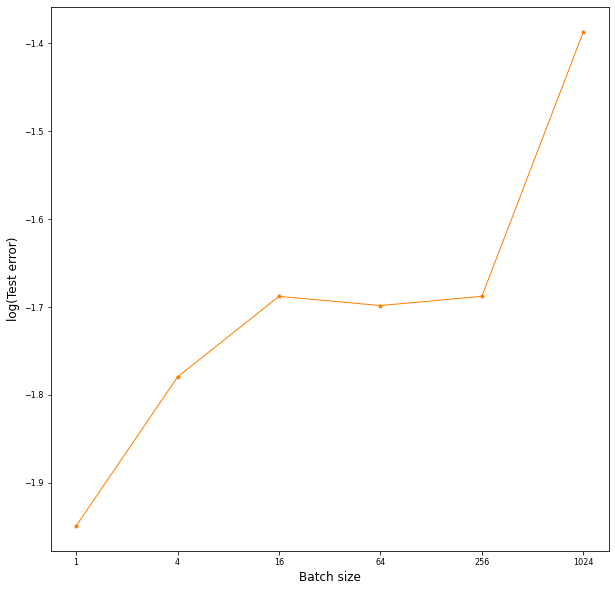

In [47]:
plot_figure("Batch size", "Test error", FLAGS["batch_size"], 
            test_errors_list_batch, xticks=FLAGS["batch_size"], save_path=test_error_path)

In [48]:
bounds_batchs = [[],[],[]] 

for k in range(FLAGS["n_experiments"]):
    spectral_norms = [np.linalg.norm(w, ord=2) for w in free_device(final_weights_list_batch[k])]
    bound_0_bat, bound_1_bat, bound_2_bat = get_bounds_mnist(free_device(initial_weights_4), free_device(final_weights_list_batch[k]), \
                                                             spectral_norms, training_dataset_batch.tensors[0], **FLAGS)
    bounds_batchs[0] += [bound_0_bat]
    bounds_batchs[1] += [bound_1_bat]
    bounds_batchs[2] += [bound_2_bat]

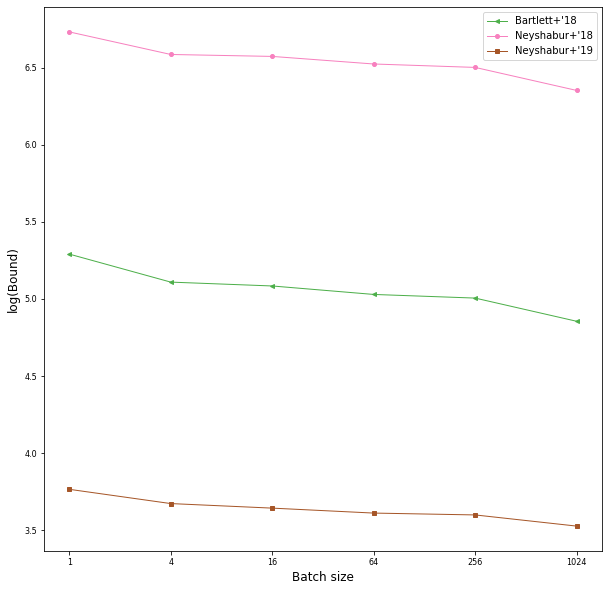

In [50]:
plot_figure("Batch size", "Bound", FLAGS["batch_size"], bounds_batchs, xticks=FLAGS["batch_size"], 
            save_path=test_bound_path,ylabels=["Bartlett+'18", "Neyshabur+'18", "Neyshabur+'19"])